<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snow_runoff_prediction_with_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tansformer for Time series forecasting


In [12]:
# !pip install keras_tuner

## Import the Library

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt

# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from tensorflow import keras
from tensorflow.keras import layers


Using TensorFlow backend


# Data pre-processing

In [2]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


In [3]:
# feature Selection

features = ['Date',"Q","SCA","T"]
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

# Data Visualization

In [4]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)



<ipython-input-4-d044043dcb90>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


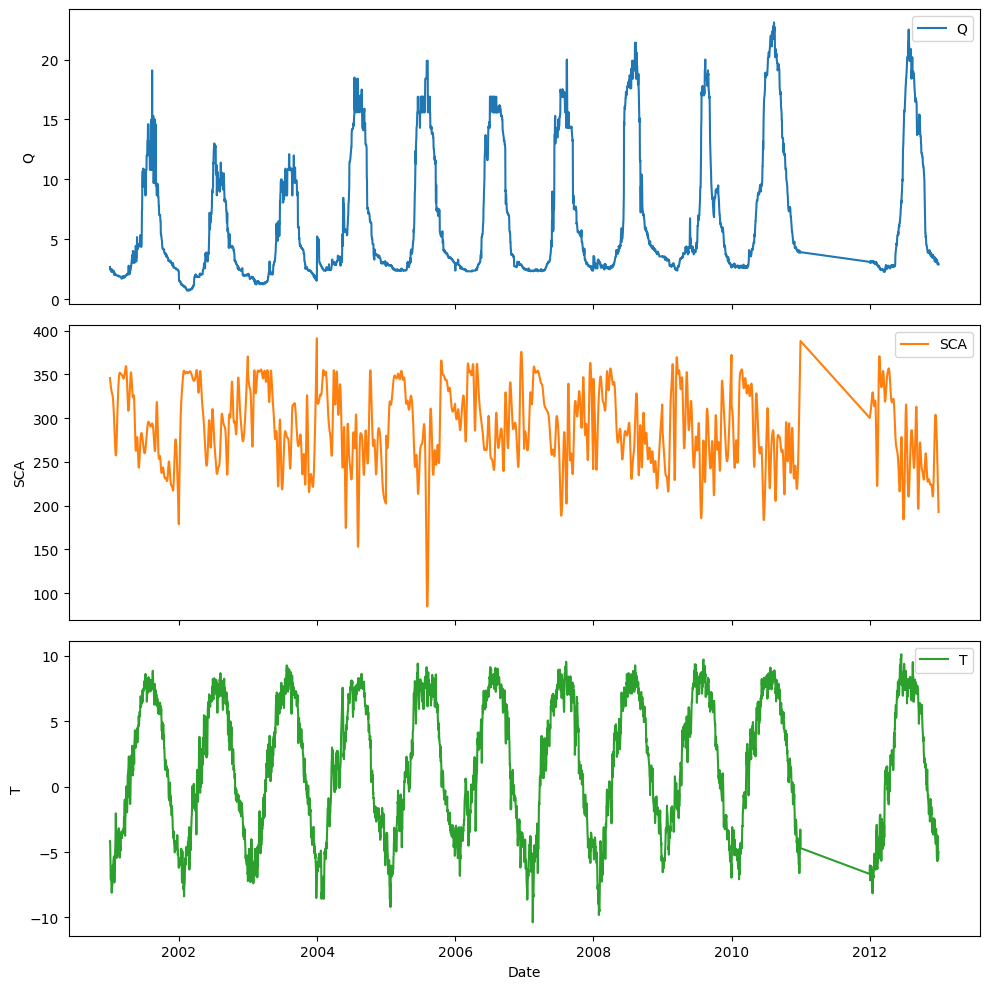

In [5]:
columns_to_plot = ['Q', 'SCA', 'T']

# Create subplots for each column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(columns_to_plot):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [6]:
df_input = df_snow_melting[['Q','SCA', 'T']]


scaler = MinMaxScaler()

# Select the features you want to scale
features_to_scale = ['Q', 'SCA', 'T']

# Fit the scaler to the data and transform the selected features
df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


<ipython-input-6-87c1da93d2bb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


In [7]:
#[[[1],[2],[3],[4],[5]]][6]
#[[[2],[3],[4],[5],[6]]][7]
#[[[3],[4],[5],[6],[7]]][8]

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)



# Time step
WINDOW_SIZE = 2

X, y = df_to_X_y(df_input,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [8]:
X_train, y_train = X[:3285],y[:3285] # 9 year 80%
X_val, y_val = X[3285:3648],y[3285:3648] # 363 days 10%
X_test, y_test = X[3648:],y[3648:]  # 364 day 10%


In [9]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

# number of features
num_features =  X_train.shape[2]


# Transformer Architecture

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [17]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [23]:
input_shape = X_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=32,
#     num_heads=2,
#     ff_dim=2,
#     num_transformer_blocks=2,
#     mlp_units=[64], # number of layers in perceptron
#     mlp_dropout=0.4,
#     dropout=0.1,
# )
model = build_model(
    input_shape,
    head_size=32,
    num_heads=2,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[32], # number of layers in perceptron
    mlp_dropout=0.4,
    dropout=0.1,
)


optimizer = Adamax(learning_rate=0.002,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mae',RootMeanSquaredError()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2, 3)]               0         []                            
                                                                                                  
 layer_normalization_4 (Lay  (None, 2, 3)                 6         ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_2 (Mu  (None, 2, 3)                 963       ['layer_normalization_4[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_4[0][0]
                                                                    ']                      

In [24]:
cp = ModelCheckpoint('model_32_layer_1/',save_best_only=True)
es = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=100,
    batch_size=32,
    callbacks=[cp,es],
)

Epoch 1/100
103/103 [==============================] - 10s 60ms/step - loss: 0.0385 - mae: 0.1262 - root_mean_squared_error: 0.1962 - val_loss: 0.0211 - val_mae: 0.1131 - val_root_mean_squared_error: 0.1453
Epoch 2/100
103/103 [==============================] - 5s 47ms/step - loss: 0.0170 - mae: 0.0860 - root_mean_squared_error: 0.1305 - val_loss: 0.0098 - val_mae: 0.0786 - val_root_mean_squared_error: 0.0991
Epoch 3/100
103/103 [==============================] - 5s 45ms/step - loss: 0.0131 - mae: 0.0768 - root_mean_squared_error: 0.1147 - val_loss: 0.0088 - val_mae: 0.0757 - val_root_mean_squared_error: 0.0937
Epoch 4/100
103/103 [==============================] - 1s 9ms/step - loss: 0.0121 - mae: 0.0737 - root_mean_squared_error: 0.1099 - val_loss: 0.0103 - val_mae: 0.0822 - val_root_mean_squared_error: 0.1015
Epoch 5/100
103/103 [==============================] - 6s 60ms/step - loss: 0.0096 - mae: 0.0664 - root_mean_squared_error: 0.0982 - val_loss: 0.0068 - val_mae: 0.0647 - val_ro

# Model Evaulation

103/103 [==============================] - 1s 3ms/step
MAE: 0.03797273183006208
RMSE: 0.0505857359964647
R-squared (R2): 0.9491478799922373


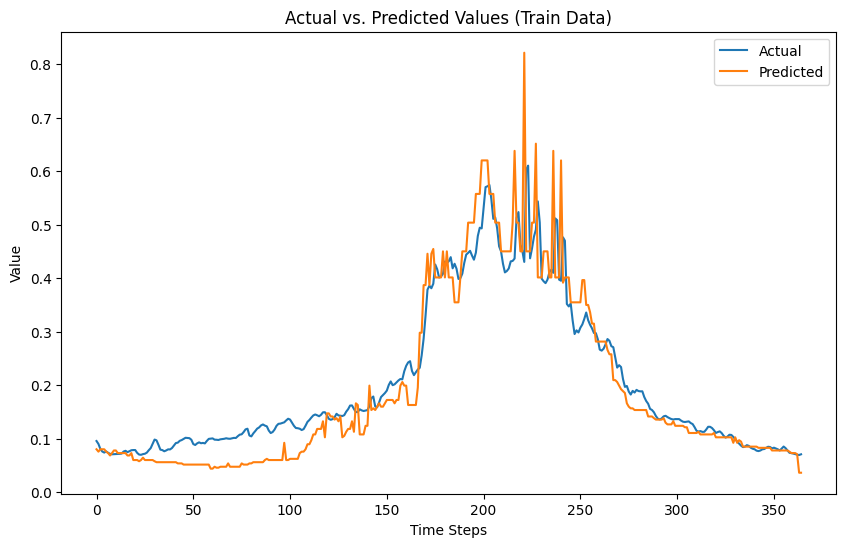

In [25]:

train_predictions = model.predict(X_train).flatten()
# train_predictions.shape
train_result = pd.DataFrame(data={"Train Predictions":train_predictions,"Actuals":y_train})
# Calculate MAE
mae = mean_absolute_error(y_train, train_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

# Calculate R2
r2 = r2_score(y_train, train_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)



plt.figure(figsize=(10, 6))
plt.plot(train_result['Train Predictions'][0:365], label='Actual')
plt.plot(train_result['Actuals'][0:365], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Train Data)')
plt.legend()
plt.show()

12/12 [==============================] - 0s 3ms/step
MAE: 0.0537056159987278
RMSE: 0.07030759537008038
R-squared (R2): 0.9476900513834765


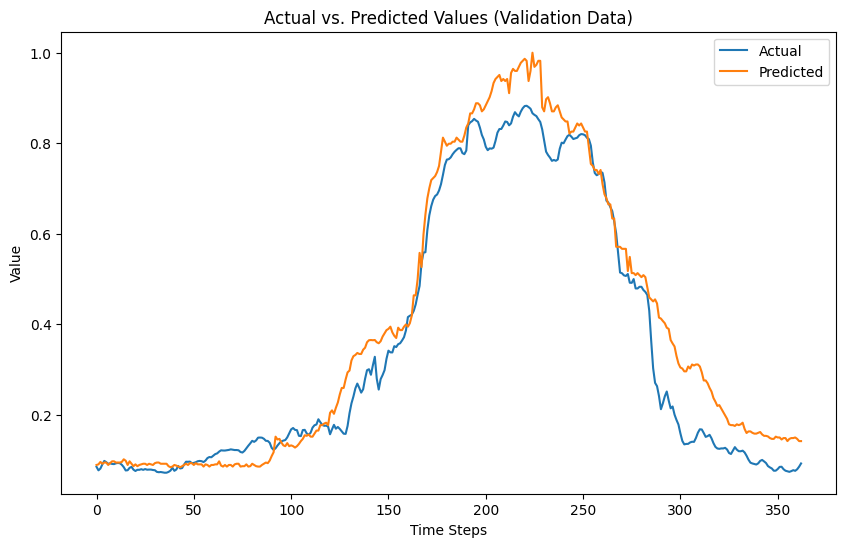

In [26]:
val_predictions = model.predict(X_val).flatten()


# Calculate MAE
mae = mean_absolute_error(y_val, val_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Calculate R2
r2 = r2_score(y_val, val_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


val_result = pd.DataFrame(data={"val Predictions":val_predictions,"Actuals":y_val})


plt.figure(figsize=(10, 6))
plt.plot(val_result['val Predictions'], label='Actual')
plt.plot(val_result['Actuals'], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Validation Data)')
plt.legend()
plt.show()

12/12 [==============================] - 0s 3ms/step
MAE: 0.038846389779977855
RMSE: 0.04622830540027888
R-squared (R2): 0.9729613580846656


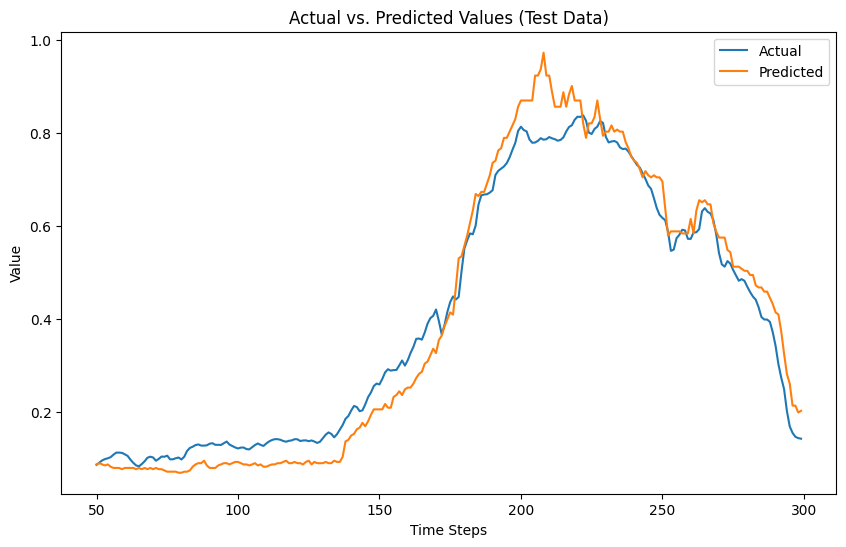

In [27]:
test_predictions = model.predict(X_test).flatten()

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate R2
r2 = r2_score(y_test, test_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


test_result = pd.DataFrame(data={"test Predictions":test_predictions,"Actuals":y_test})

plt.figure(figsize=(10, 6))
plt.plot(test_result['test Predictions'][50:300], label='Actual')
plt.plot(test_result['Actuals'][50:300], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

# Hyperparameter Tuning

In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [15]:
def build_tf_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [29]:
def build_model(hp):


    inputs = keras.Input(shape=input_shape)
    x = inputs

    for i in range(hp.Int('num_transformer_blocks', min_value=2, max_value=8,step=2)):
        x = transformer_encoder(x,
                               hp.Int('head_size', min_value=8, max_value=256, step=32),
                               hp.Int('num_heads', min_value=2, max_value=16),
                               hp.Int('ff_dim', min_value=4, max_value=64),
                               hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for i in range(hp.Int('num_mlp_layers', min_value=1, max_value=3)):
        x = layers.Dense(hp.Int(f'mlp_units_{i}', min_value=32, max_value=256,step=32))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.6))(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Choose optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mae', RootMeanSquaredError()])

    return model

# Initialize the Keras Tuner Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='keras_tuner_dir',
    project_name='hyperparameter_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

# Get the b

Trial 90 Complete [00h 01m 51s]
val_loss: 0.023876983672380447

Best val_loss So Far: 0.0005769158015027642
Total elapsed time: 01h 18m 37s


In [1]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# best_hps
# Build and compile the model with the best hyperparameters
model = build_model(best_hps)

model.summary()

# Train the model

# This code uses Kera

NameError: ignored

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)